In [1]:
# Note: this uses matplotlib 2.0 and librosa 0.5dev
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg
import matplotlib.style as ms
ms.use('seaborn-muted')
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

In [2]:
import matplotlib
#matplotlib.rcParams.update({'font.size': 10})

In [3]:
y, sr = librosa.load('../../tests/mandolin_trem.mp3', sr=None, offset=0.75, duration=0.5)
#y, sr = librosa.load('../../tests/sax_cres.mp3', sr=None, offset=0.75, duration=0.5)

In [4]:
fmin = librosa.note_to_hz('C3')
OVERSAMPLE = 3
N_OCT = 7

C = librosa.cqt(y=y, sr=sr, bins_per_octave=OVERSAMPLE*12, n_bins=N_OCT*OVERSAMPLE*12,
                hop_length=128, fmin=fmin)

freqs = librosa.cqt_frequencies(C.shape[0], fmin, bins_per_octave=OVERSAMPLE*12)
fmax = freqs.max()

In [5]:
Cl = librosa.logamplitude(C**2, ref_power=np.max, amin=1e-5, top_db=60)

In [6]:
ms.use('seaborn-paper')

<IPython.core.display.Javascript object>


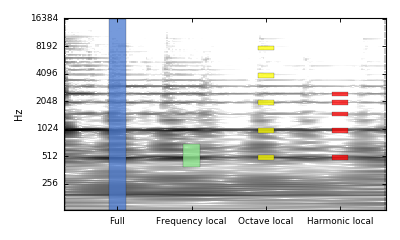

In [7]:
plt.figure(figsize=(5, 3))


# Draw the spectrogram
ax = librosa.display.specshow(Cl, y_axis='cqt_hz', sr=sr, cmap='gray_r',
                              bins_per_octave=OVERSAMPLE*12, fmin=librosa.note_to_hz('C3'))


# Draw the full-height filter
ax.add_patch(patches.Rectangle((24, fmin), 9, fmax - fmin, alpha=0.75, edgecolor='k', label='Full height'))

# Draw a local filter
ax.add_patch(patches.Rectangle((64, librosa.note_to_hz('G4')),
                               9, 
                               librosa.note_to_hz('F5') - librosa.note_to_hz('G4'),
                               facecolor='lightgreen',edgecolor='k', 
                               alpha=0.75, label='Frequency-local'))


# Draw octave-local filters
base_f = librosa.note_to_hz('Cb5')


filters = []
for harm in [1, 2, 4, 8, 16]:
    bottom = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) - 1) # go down 3 semitones
    top = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) + 1)
    filters.append(patches.Rectangle((104, bottom), 9, top - bottom))


pc = PatchCollection(filters, facecolor='yellow', edgecolor='k', alpha=0.75, label='Octave-local')
pc.set_label('Octave-local')
ax.add_collection(pc)



# Draw harmonics
filters = []
for harm in [1, 2, 3, 4, 5]:
    bottom = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) - 1) # go down 3 semitones
    top = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) + 1)
    filters.append(patches.Rectangle((144, bottom), 9, top - bottom))

    
pc = PatchCollection(filters, facecolor='red', edgecolor='k', alpha=0.75, label='Harmonic-local')
pc.set_label('Harmonic-local')
ax.add_collection(pc)

plt.xticks([24+4.5, 64+4.5, 104+4.5, 144+4.5],
          ['Full', 'Frequency local', 'Octave local', 'Harmonic local'])
plt.tight_layout()

plt.savefig('filter-shapes.pdf', transparent=False, pad_inches=0)

In [8]:
from IPython.display import Audio

In [9]:
Audio(data=y, rate=sr)

In [10]:
OC = librosa.harmonics(Cl, freqs, h_range=[1,2,4,8,16], fill_value=Cl.min())

In [11]:
harmonics = [1, 2, 3, 4, 5]
HC = librosa.harmonics(Cl, freqs, h_range=harmonics, fill_value=Cl.min())

<IPython.core.display.Javascript object>


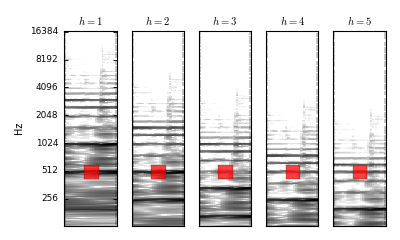

In [12]:
plt.figure(figsize=(5, 3))


for i, h in enumerate(harmonics, 1):
    plt.subplot(1, len(harmonics), i)
    
    ax = librosa.display.specshow(HC[i-1,:, 32:64], y_axis='cqt_hz', sr=sr, cmap='gray_r',
                                  bins_per_octave=OVERSAMPLE*12, fmin=h * freqs.min())
    if i > 1:
        #plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_yticks([])
        ax.set_ylabel('')
    
    bottom = librosa.midi_to_hz(librosa.hz_to_midi(base_f * h) - 3) # go down 3 semitones
    top = librosa.midi_to_hz(librosa.hz_to_midi(base_f * h) + 3)
    ax.add_patch(patches.Rectangle((16-4, bottom), 9, top - bottom, facecolor='red', edgecolor='k', alpha=0.75))
    
    plt.title(r'$h={}$'.format(h))
plt.tight_layout()
plt.savefig('hcnn.pdf', transparent=False, pad_inches=0)

<IPython.core.display.Javascript object>


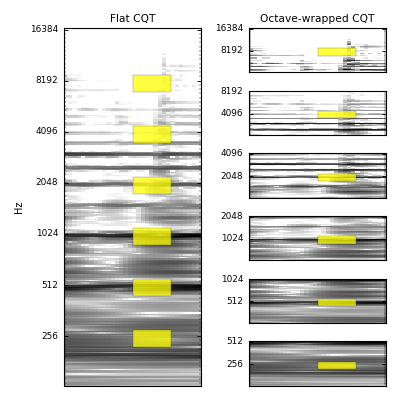

In [13]:
plt.figure(figsize=(5, 5))

ax = plt.subplot(1, 2, 1)
librosa.display.specshow(Cl[:, 32:64], y_axis='cqt_hz', sr=sr, cmap='gray_r',
                         bins_per_octave=OVERSAMPLE*12, fmin=freqs[0])

base_f = librosa.note_to_hz('Cb4')

filters = []
for harm in [1, 2, 4, 8, 16, 32]:
    bottom = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) - 2) # go down 3 semitones
    top = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) + 2)
    filters.append(patches.Rectangle((16, bottom), 9, top - bottom))


pc = PatchCollection(filters, facecolor='yellow', edgecolor='k', alpha=0.75)
pc.set_label('Octave-local')
ax.add_collection(pc)
ax.set_title('Flat CQT')


for i in range(N_OCT-1):
    plt.subplot(N_OCT-1, 2, 2 * (N_OCT -1 - i))
    
    ax = librosa.display.specshow(Cl[i * OVERSAMPLE * 12:((i + 2) * OVERSAMPLE*12), 32:64],
                                  y_axis='cqt_hz', 
                                  sr=sr,
                                  cmap='gray_r',
                                  bins_per_octave=OVERSAMPLE*12, fmin=freqs[i * OVERSAMPLE * 12])
    ax.set_ylabel('')
    
    harm = 2**i
    bottom = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) - 2) # go down 3 semitones
    top = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) + 2)
    ax.add_patch(patches.Rectangle((16, bottom), 9, top - bottom, facecolor='yellow', alpha=0.75))
    
    #bottom = librosa.midi_to_hz(librosa.hz_to_midi(base_f * h) - 3) # go down 3 semitones
    #top = librosa.midi_to_hz(librosa.hz_to_midi(base_f * h) + 3)
    #ax.add_patch(patches.Rectangle((16-4, bottom), 9, top - bottom, facecolor='red', edgecolor='k', alpha=0.75))
    
    #plt.title(r'$h={}$'.format(h))
    if i == N_OCT - 2:
        ax.set_title('Octave-wrapped CQT')
        
plt.tight_layout()
plt.savefig('octave-local.pdf', transparent=False, pad_inches=0)

In [14]:
from sklearn.datasets import load_sample_image

In [15]:
im = load_sample_image('china.jpg')

In [16]:
im.shape

(427, 640, 3)

<IPython.core.display.Javascript object>


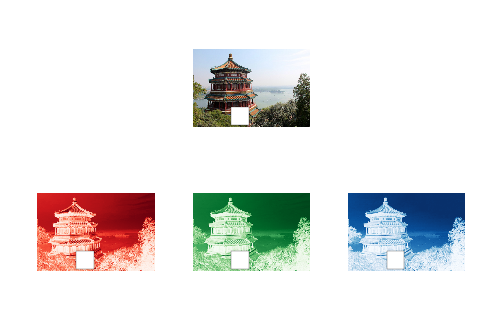

In [17]:
plt.figure(figsize=(6, 4))

xy = (im.shape[0] // 2, im.shape[1] // 2)

ax = plt.subplot(2,3,2)
ax.imshow(im)
ax.axis('off')
ax.add_patch(patches.Rectangle(xy, 96, 96, facecolor='w', alpha=1, edgecolor='k'))

for i in range(3):
    ax = plt.subplot(2, 3, 3 + (i + 1))
    ax.imshow(im[:, :, i], cmap=['Reds', 'Greens', 'Blues'][i])
    ax.axis('off')
    ax.add_patch(patches.Rectangle(xy, 96, 96, facecolor='w', alpha=1, edgecolor='k'))
    
plt.tight_layout()

In [18]:
cifar = np.load('../../data/cifar_ave_pixel_corr.npy')

<IPython.core.display.Javascript object>


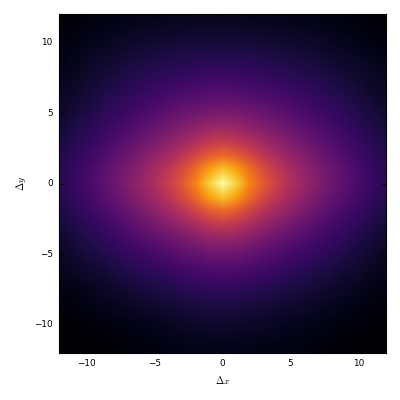

In [19]:
x_dim, y_dim = cifar.shape[0]//2, cifar.shape[1]//2

plt.figure(figsize=(5, 5))
plt.imshow(cifar / cifar.max(), cmap='inferno', aspect='auto', extent=(-x_dim, x_dim, -y_dim, y_dim))
plt.xlabel(r'$\Delta x$')
plt.ylabel(r'$\Delta y$')
#plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.savefig('cifar-corr.pdf', transparent=False, pad_inches=0)

In [20]:
cqtcov = np.load('../../data/cqt_ave_tf_corr.npy').T

In [21]:
# CQT parameters:
# time extent = +- 6
# frequency extent = +- two octaves
cqtcov.shape
BPO = 24

<IPython.core.display.Javascript object>


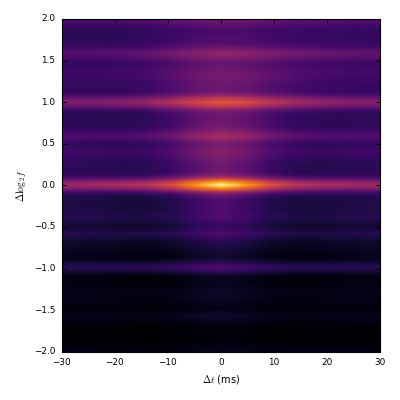

In [22]:
plt.figure(figsize=(5, 5))

t_dim = cqtcov.shape[1]//2 * 5
f_dim = cqtcov.shape[0]//2 / (BPO)

plt.imshow(cqtcov / cqtcov.max(), cmap='inferno', aspect='auto',
           extent=(-t_dim, t_dim, -f_dim, f_dim))

plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel(r'$\Delta \log_2 f$')
#plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.savefig('uspop-corr.pdf', transparent=False, pad_inches=0)

In [23]:
np.log2(3)

1.5849625007211561